In [1]:
import csv
import cv2
import matplotlib.pyplot as plt

import numpy as np
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
import sklearn as skl
import random

Using TensorFlow backend.


In [2]:
# Read the CSV file for getting all the filenames and their respective steering values
def read_csv_files():
    lines = []
    with open('data/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    return lines

def read_images():
    images = []
    measurements= []
    for line in lines:
        center_fname = line[0].split('/')[-1]
        left_fname = line[1].split('/')[-1]
        right_fname = line[2].split('/')[-1]
        
        # We store the 3rd column in line because that contains the steering value for all images 
        # (one from center camera, left camera and right camera)
        measurement = float(line[3])
        
        center_fpath = 'data/IMG/' + center_fname
        left_fpath = 'data/IMG/' + left_fname
        right_fpath = 'data/IMG/' + right_fname
        
        center_image = cv2.imread(center_fpath)
        left_image = cv2.imread(left_fpath)
        right_image = cv2.imread(right_fpath)
        
        # Change the color space here to YUV from BGR
        center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2YUV)
        left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2YUV)
        right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2YUV)
        
        # Here we offset each of the respective measurement for right and left camera by adding/subtracting the 
        # offset from center camera angle value.
        new_measurement = 0.22
        left_measurement = measurement + new_measurement
        right_measurement = measurement - new_measurement
        
        # Since the track on which data is recorded and even though we have one lap of reverse driving on track, 
        # we need to randomly flip the images so that values of steering angle are evenly balanced around value 0 
        # (i.e. approximately equal number of -ve and +ve steering values)
        if random.randint(0,3) == 1:
            center_image = np.fliplr(center_image)
            measurement = -measurement
        if random.randint(0,3) == 3:
            left_image = np.fliplr(left_image)
            left_measurement = -left_measurement
        if random.randint(0,3) == 2:
            right_image = np.fliplr(right_image)
            right_measurement = -right_measurement
        
        images.extend((center_image, left_image, right_image))
        measurements.extend((measurement, left_measurement, right_measurement))
        
    return images, measurements

# Read both Images and measurement of steering angles into NP array.
lines = read_csv_files()   
input_images, input_measurements = read_images()


In [3]:
X_train = np.array(input_images)
Y_train = np.array(input_measurements)

skl.utils.shuffle(X_train, Y_train)
print (type(X_train), X_train.shape)

<class 'numpy.ndarray'> (59016, 160, 320, 3)


In [4]:

model = Sequential()
model.add(Cropping2D(((70,25), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: (x / 255.) - 0.5))

# NVIDIA End-to-end Self driving cars

#apply a 5x5 convolution with 24 output filters on a 160x320x3 image:
model.add(Convolution2D( 24, 5, 5, subsample=(2, 2), border_mode="valid", activation="relu"))
#apply a 5x5 convolution with 36 output filters
model.add(Convolution2D( 36, 5, 5, subsample=(2, 2), border_mode="valid", activation="relu"))
#apply a 5x5 convolution with 48 output filters
model.add(Convolution2D( 48, 5, 5, subsample=(2, 2), border_mode="valid", activation="relu"))
#apply a 3x3 convolution with 64 output filters
model.add(Convolution2D( 64, 3, 3, subsample=(1, 1), border_mode="valid", activation="relu"))
#apply a 3x3 convolution with 64 output filters
model.add(Convolution2D( 64, 3, 3, subsample=(1, 1), border_mode="valid", activation="relu"))

model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

# Saving the model into a history object to find loss trend for training and validation sets.
history_object = model.fit(X_train, Y_train, validation_split=0.2, shuffle=True, nb_epoch=7)

model.save('model.h5')

Train on 47212 samples, validate on 11804 samples
Epoch 1/7
47212/47212 [==============================] - 285s - loss: 0.0208 - val_loss: 0.0183
Epoch 2/7
47212/47212 [==============================] - 288s - loss: 0.0189 - val_loss: 0.0172
Epoch 3/7
47212/47212 [==============================] - 285s - loss: 0.0182 - val_loss: 0.0179
Epoch 4/7
47212/47212 [==============================] - 287s - loss: 0.0175 - val_loss: 0.0185
Epoch 5/7
47212/47212 [==============================] - 288s - loss: 0.0168 - val_loss: 0.0184
Epoch 6/7
47212/47212 [==============================] - 288s - loss: 0.0164 - val_loss: 0.0180
Epoch 7/7
47212/47212 [==============================] - 288s - loss: 0.0157 - val_loss: 0.0183


dict_keys(['loss', 'val_loss'])


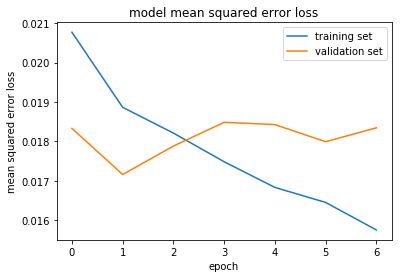

In [5]:
### print the keys contained in the history object

print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()